In [1]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=1000)

from scipy.optimize import minimize


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

import time

## Iterative SLSQP

In [2]:
# define helper functions

def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

# Define the objective function
def objective(phi, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the objective function
def objective2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init) + np.linalg.norm(A_ @ phi - b_)

def nearest_center(shape, n):
    near_cent = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                z_cent = z
                y_cent = y
                x_cent = x
                if (x-n < 0):
                    x_cent = n
                elif (shape[2]-x < n+1):
                    x_cent = shape[2]-n-1

                if (y-n < 0):
                    y_cent = n
                elif (shape[1]-y < n):
                    y_cent = shape[1]-n-1
                center_indices = [z, y_cent, x_cent]
                near_cent[l_idx] = center_indices
                # print("Nearest center values for index ", l_idx, center_indices)
    return near_cent

def original_coordinates(shape):
    ori_coord = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                ori_coord[z * shape[1] * shape[2] + y * shape[2] + x] = (z,y,x)
    return ori_coord


def get_phi_sub(phi, cz, cy, cx, shape, d):
    phix = phi[1][cy-d:cy+d+1, cx-d:cx+d+1]
    phiy = phi[0][cy-d:cy+d+1, cx-d:cx+d+1]
    return np.concatenate([phix.flatten(), phiy.flatten()])

def jacobian_det2D(phi_xy):
    deformation = np.zeros((3,1, *phi_xy.shape[-2:])    )
    deformation[2] = phi_xy[1]
    deformation[1] = phi_xy[0]
    return jacobian.sitk_jacobian_determinant(deformation)

def jdet_constraint2(phi_sub, phi, idx_sub, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, ori_shape, epsilon=1e-6):
    dist = submatrix_size//2
    pixels = submatrix_size*submatrix_size
    phi[1][cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[:pixels].reshape((submatrix_size, submatrix_size))
    phi[0][cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[pixels:].reshape((submatrix_size, submatrix_size))

    phi = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    z,y,x = sub_ori_coord[idx_sub]
    z = z
    y = y+cy-dist
    x = x+cx-dist 

    idx = laplacian.get_laplacian_index(z,y,x, ori_shape)


    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
        
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx)# - epsilon

In [3]:
def iterative_with_jacobians(deformation_i, methodName='SLSQP'):
    '''perform SLSQP on submatrices iteratively'''
    slice_shape = (1, *deformation_i.shape[-2:])

    # this phi will be updated iteratively
    phi = np.zeros((2, *deformation_i.shape[-2:]))
    phi[1] = deformation_i[-1]
    phi[0] = deformation_i[-2]
    print(f'deformation_i shape: {deformation_i.shape}, phi_init shape: {phi.shape}')
    phi_init = phi.copy()

    # set threshold for Jacobian and store results
    threshold = 0.0
    jacobians = []
    indi_times = []
    tot_start = time.time()

    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi)
    jacobians.append(J_init)
    J_init = J_init.flatten()
    neg_jacobian_indices = np.where(J_init <= threshold)[0]
    neg_jacobian_indices = neg_jacobian_indices[np.argsort(J_init[neg_jacobian_indices])].tolist()
    print(f'init: Negative Jacobians found at {neg_jacobian_indices}')

    # set values to use inside the while loop
    idx_adj = idx_adjacency(slice_shape)
    y_offset = len(J_init)//2
    # find the nearest center of a 5x5 matrix around each pixel
    submatrix_size = 5
    near_cent = nearest_center(slice_shape, submatrix_size//2)
    ori_coord = original_coordinates(slice_shape)


    sub_shape = (1,submatrix_size, submatrix_size)
    sub_ori_coord = original_coordinates(sub_shape)
    _, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3)))

    visited = set()
    ind = 0

    
    # perform optimisation for each index with negative Jacobian
    while ind < len(neg_jacobian_indices) and ind < 50:
        neg_index  = neg_jacobian_indices[ind]
        ind += 1

        visited.add(neg_index)

        # if the negative values has already been fixed, skip it
        if (jacobian_det2D(phi).flatten()[neg_index] > threshold):
            print(f'Iter {ind}: jacobian at index {neg_index} is +ve. skip.')
            continue
        
        z,y,x = ori_coord[neg_index]
        cz, cy, cx = near_cent[neg_index]

        print(f'Iter {ind}: Analysing index {neg_index}: Original coord: {x,y,z}, nearest: {cx, cy, cz}')

        # get constraints for optimisation
        constraints = []
        for i_sub in range(len(b_sub)//2):
            constraints += [{'type': 'ineq', 'fun': lambda phi1, i=i_sub: jdet_constraint2(phi1, phi, i, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, slice_shape)}]

        op_start = time.time()

        # in objective, should i use latest phi or the very initial phi_init to penalise?
        # it is running when initial pt is new phi AND objective uses new phi!
        phi_init_sub = get_phi_sub(phi_init, cz, cy, cx, slice_shape, submatrix_size//2)
        phi_sub = get_phi_sub(phi, cz, cy, cx, slice_shape, submatrix_size//2)

        result = minimize(lambda phi1: objective2(phi1, phi_sub, A_sub, b_sub), phi_sub, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)
        
        op_end = time.time()

        print(f'Optimisation for index {neg_index} completed in {op_end-op_start}s')

        indi_times.append(op_end-op_start)
        
        if result.success:
            print(f'OP result error for index {neg_index}: {result.fun}')
        else:
            print("Optimisation failed: ", result.message)

        # substitute values from computed deformation into original phi
        # b_ was XYd, so phi_x is the first half
        phi_x_res = result.x[:len(result.x) // 2].reshape(sub_shape[-2:])
        phi_y_res = result.x[len(result.x) // 2:].reshape(sub_shape[-2:])

        center_distance = submatrix_size//2
        phi[1][cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_x_res
        phi[0][cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_y_res

        # compute jacobian and add to list
        J = jacobian_det2D(phi)
        jacobians.append(J)

        # check for -ve jacobians in modified deformation
        J = J.flatten()
        neg_j_iter = np.where(J <= threshold)[0]
        neg_j_iter = neg_j_iter[np.argsort(J[neg_j_iter])]

        print(f'Iter {ind} end: {len(neg_j_iter)} -ve jacs now at {neg_j_iter} : SITK: {J[neg_j_iter]}')

        # add new negative jacobian indices to list
        for new_neg in neg_j_iter:
            if new_neg not in neg_jacobian_indices[ind:]:
                neg_jacobian_indices.append(new_neg)


    # compute errors
    phi_flat = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    phi_init_flat = np.concatenate([phi_init[1].flatten(), phi_init[0].flatten()])

    _, A_, b_ = laplacian.compute3DLaplacianFromShape(slice_shape, np.empty((0,3)), np.empty((0,3)))
    init_error = objective2(phi_init_flat, phi_init_flat, A_, b_)
    fin_error = objective2(phi_flat, phi_init_flat, A_, b_)
    deviation = np.sqrt(np.sum((phi_flat - phi_init_flat)**2))

    tot_end = time.time()
    print(f'Total time taken for iterative SLSQP : {tot_end - tot_start} split as {indi_times}')
    print(f'Initial error: {init_error}, final error: {fin_error}, deviation: {deviation}')
    
    
    return phi, jacobians

## preprocessing and plotting methods

In [4]:
def plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10)):
    jacobian_initial = jacobian_det2D(deformation_i[1:])
    jacobian_final = jacobian_det2D(phi_corrected)

    # print("JACOBIAN SHAPES", jacobian_initial.shape, jacobian_final.shape)

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)


    # plot initial vs final Jacobian
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # jacobians are of shape (1,5,5). Use index [0] for 2D plots
    im0 = axs[0,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    axs[0,0].legend()

    axs[0,1].set_title('final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, -deformation_i[2,0], deformation_i[1,0])

    axs[1,1].set_title('final deformation')
    axs[1,1].quiver(x, y, -phi_corrected[1], phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)

In [5]:
def plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP'):
    # assume jacobians is a list of numpy arrays of shape (1, 5, 5)
    # assume msample and fsample are (N, 3) arrays

    num_jacobians = len(jacobians)
    ncols = min(2, num_jacobians)  # wrap at 2 columns
    nrows = (num_jacobians + ncols - 1) // ncols  # ceiling division

    # Compute color normalization
    all_vals = [j[0] for j in jacobians]  # extract 2D arrays from (1,5,5)
    vmin = min(j.min() for j in all_vals)
    vmax = max(j.max() for j in all_vals)
    norm = mcolors.TwoSlopeNorm(vmin=min(vmin, -1), vcenter=0, vmax=max(vmax, 1))

    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, jac in enumerate(jacobians):
        im = axs[i].imshow(jac[0], cmap='seismic', norm=norm, interpolation='nearest')
        num_negs = np.sum(jac <= 0)
        axs[i].set_title(f'Jacobian #{i}, {num_negs} -ves' if i > 0 else f'Initial J det: {num_negs} -ves')

        if i == 0:
            axs[i].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving', s=10)
            axs[i].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed', s=10)
            axs[i].legend()

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.1, headwidth=3, headlength=5, width=1)
        )

    # Hide any extra axes
    for j in range(len(jacobians), len(axs)):
        axs[j].axis('off')

    # Add colorbar
    # cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    # fig.colorbar(im, cax=cax)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

def run_lapl_and_correction(fixed_sample, msample, fsample, methodName='SLSQP'):
    '''plot each Jacobian matrix'''
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    print(f'deformation shape: {deformation_i.shape}')
    phi_corrected, jacobians = iterative_with_jacobians(deformation_i, methodName)
    plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
    plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))

## Testcases

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [3, 13, 2]
Iter 1: Analysing index 3: Original coord: (3, 0, 0), nearest: (3, 2, 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.765776369815893
            Iterations: 42
            Function evaluations: 2185
            Gradient evaluations: 42
Optimisation for index 3 completed in 0.4258561134338379s
OP result error for index 3: 4.765776369815893
Iter 1 end: 1 -ve jacs now at [3] : SITK: [-0.00105592]
Iter 2: jacobian at index 13 is +ve. skip.
Iter 3: jacobian at index 2 is +ve. skip.
Iter 4: Analysing index 3: Original coord: (3, 0, 0), nearest: (3, 2, 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.7917167406994357
            Iterations: 27
            Function evaluations: 1440
            Gradient evaluations: 27
Optimisation for index 3 completed in 0.2

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_60876/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


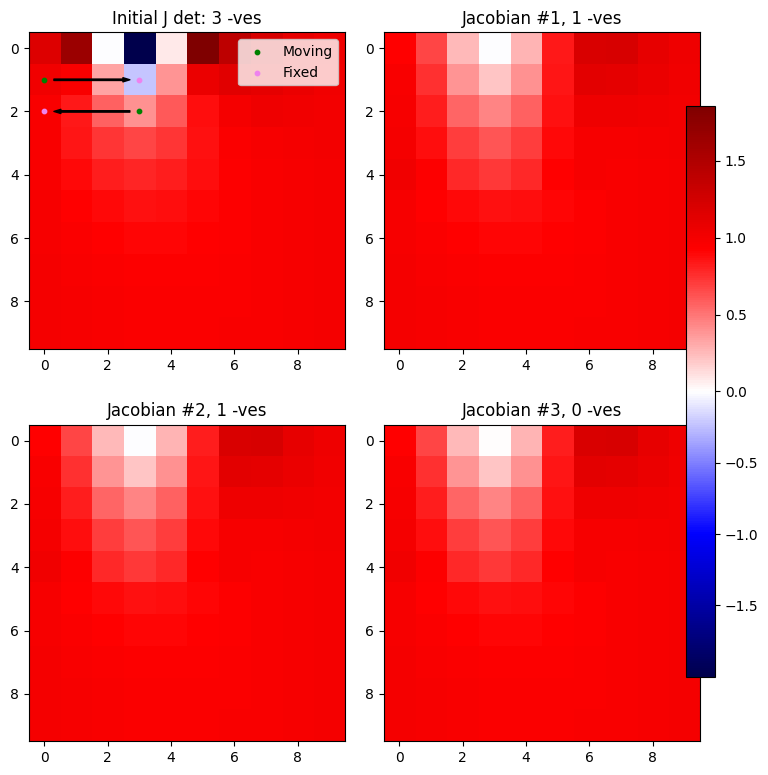

            x-def               y-def           jacobian          
              min       max       min      max       min       max
initial -2.999704  2.999704  0.000000  0.00000 -1.999704  1.852443
final   -1.407856  1.705421 -0.000042  0.00008  0.000095  1.202398
meshgrid shape for plot: (10, 10)


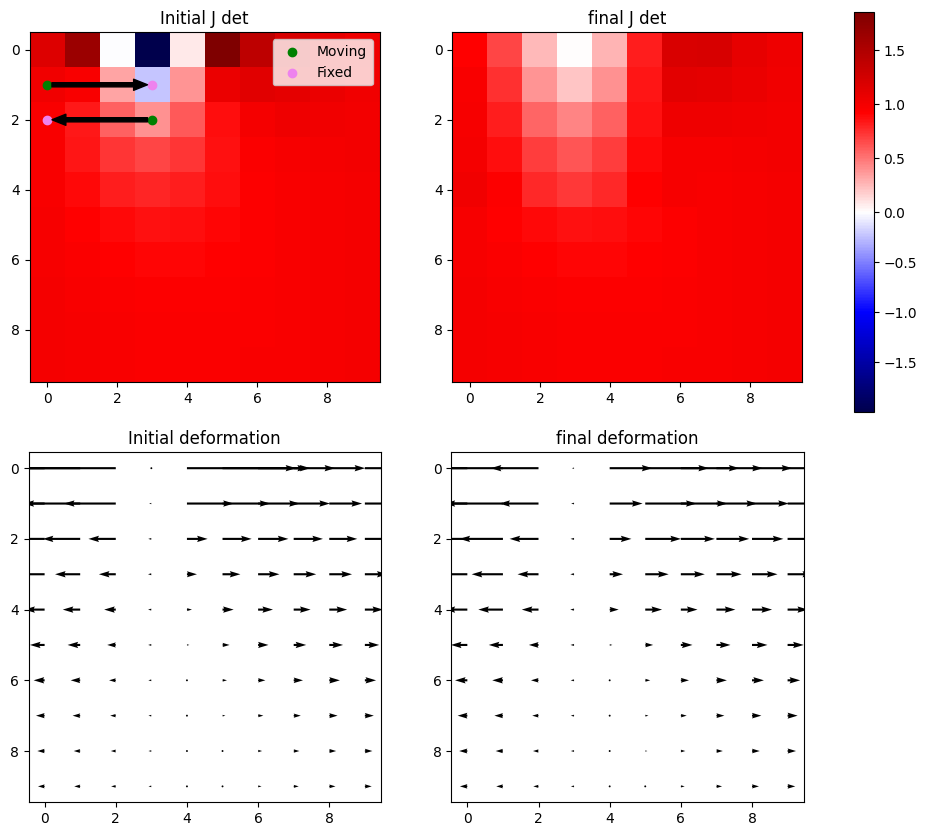

In [6]:
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 10, 10)) # depth, rows, cols

run_lapl_and_correction(fixed_sample, msample, fsample)

# takes 15 mins and does not conclude on full 20x40 constraints
# 1.5mins on 10x10 constraints
# reduce constraints
# (10,5) - 50 vs 5 - 3.9s vs 0.15s
# (5,5) - 25 vs 5 - 0.35s vs 0.0645s
# (10, 10) - 100 vs 5 - 50s vs 0.46s
# (20, 20) - 400 vs 5 - waited for full one to run for 20min vs 1.5min

# 20x40 with 5 random constraints - 10.5 mins
# 20x40 run over the full thing - 174 min does not finish

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [14]
Iter 1: Analysing index 14: Original coord: (4, 1, 0), nearest: (4, 2, 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.847007369119687
            Iterations: 23
            Function evaluations: 1207
            Gradient evaluations: 23
Optimisation for index 14 completed in 0.2162768840789795s
OP result error for index 14: 4.847007369119687
Iter 1 end: 0 -ve jacs now at [] : SITK: []
Total time taken for iterative SLSQP : 0.26529574394226074 split as [0.2162768840789795]
Initial error: 8.301991792387227, final error: 6.278933312831073, deviation: 3.4380953627754947


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_60876/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


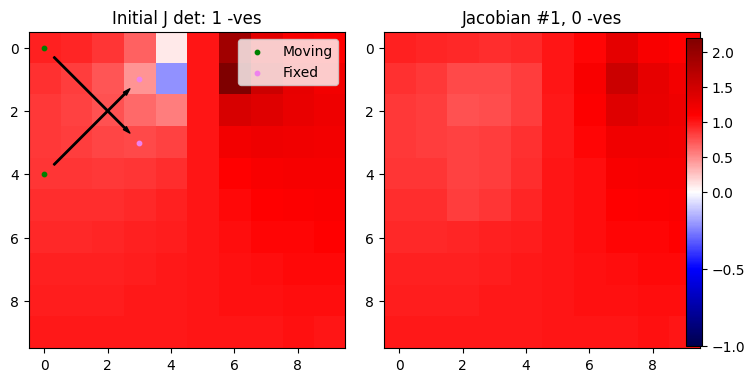

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.006613 -2.972020 -2.999864  2.999864 -0.215728  2.197900
final   -3.006613 -2.967815 -1.942365  1.410595  0.753639  1.534944
meshgrid shape for plot: (10, 10)


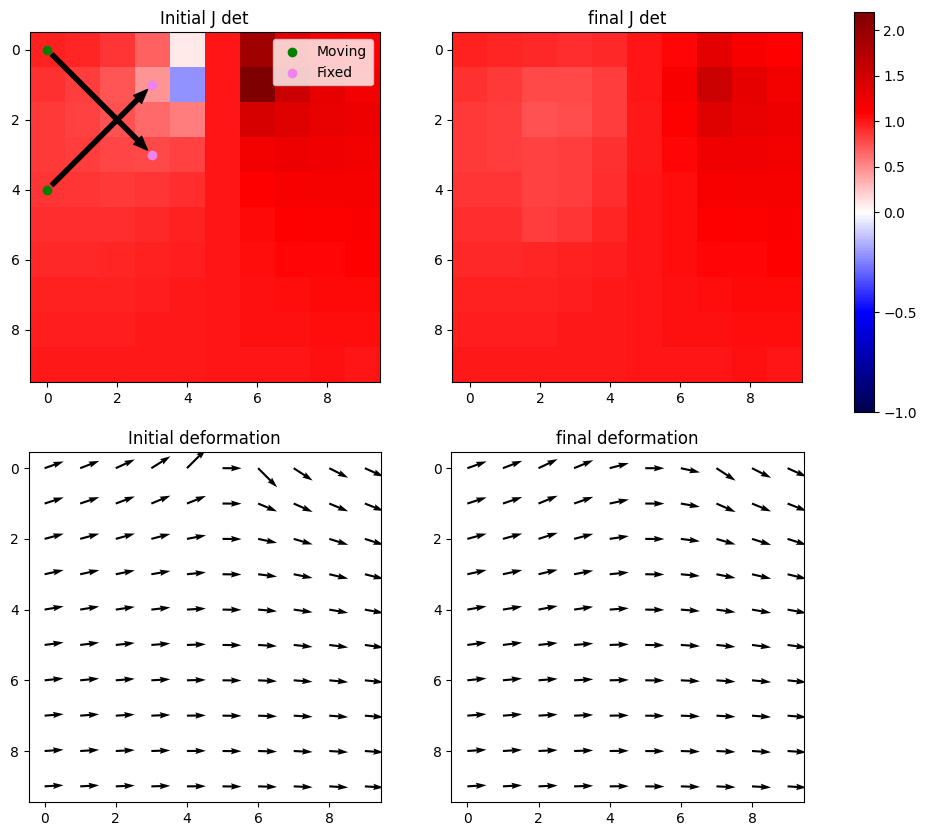

In [7]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [13]
Iter 1: Analysing index 13: Original coord: (3, 1, 0), nearest: (3, 2, 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.8484771784667675
            Iterations: 26
            Function evaluations: 1362
            Gradient evaluations: 26
Optimisation for index 13 completed in 0.24339675903320312s
OP result error for index 13: 4.8484771784667675
Iter 1 end: 0 -ve jacs now at [] : SITK: []
Total time taken for iterative SLSQP : 0.2929220199584961 split as [0.24339675903320312]
Initial error: 8.301903173025687, final error: 6.184083862483683, deviation: 3.3813141564981515


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_60876/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


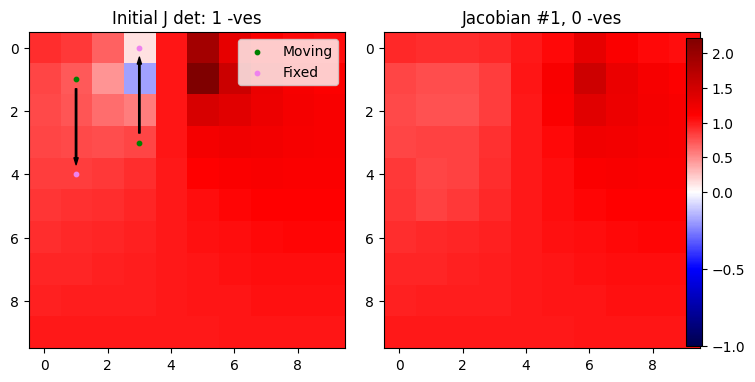

        x-def               y-def            jacobian          
          min       max       min       max       min       max
initial   0.0  0.000000 -2.999864  2.999864 -0.184744  2.216894
final     0.0  0.019501 -1.875843  1.517597  0.745843  1.528240
meshgrid shape for plot: (10, 10)


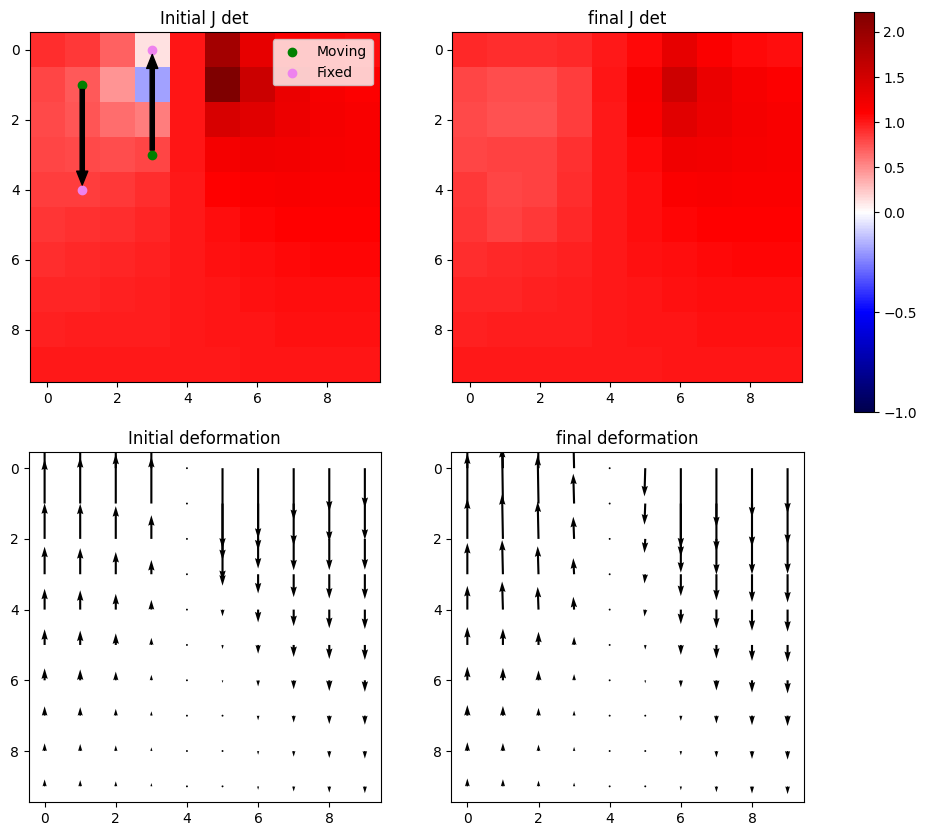

In [8]:
msample = np.array([
    [0, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [5, 6]
Iter 1: Analysing index 5: Original coord: (5, 0, 0), nearest: (5, 2, 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.6551413524593226
            Iterations: 38
            Function evaluations: 1985
            Gradient evaluations: 38
Optimisation for index 5 completed in 0.3502378463745117s
OP result error for index 5: 2.6551413524593226
Iter 1 end: 0 -ve jacs now at [] : SITK: []
Iter 2: jacobian at index 6 is +ve. skip.
Total time taken for iterative SLSQP : 0.39956188201904297 split as [0.3502378463745117]
Initial error: 6.566029817740786, final error: 2.7970307368681238, deviation: 2.04260778228698


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_60876/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


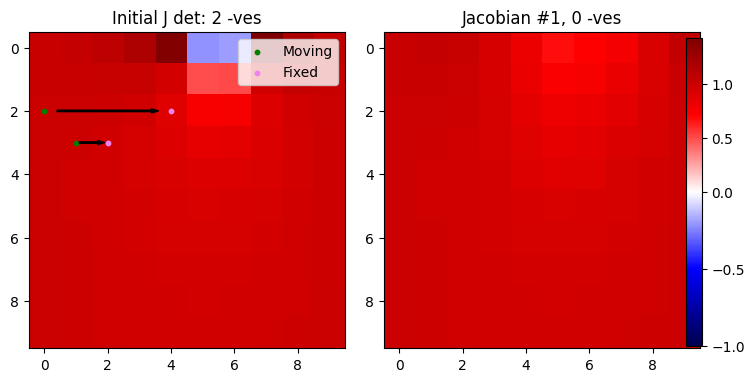

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.999655 -0.999914  0.000000  0.000000 -0.217001  1.428312
final   -3.143030 -1.893955 -0.000115  0.000098  0.675492  1.045301
meshgrid shape for plot: (10, 10)


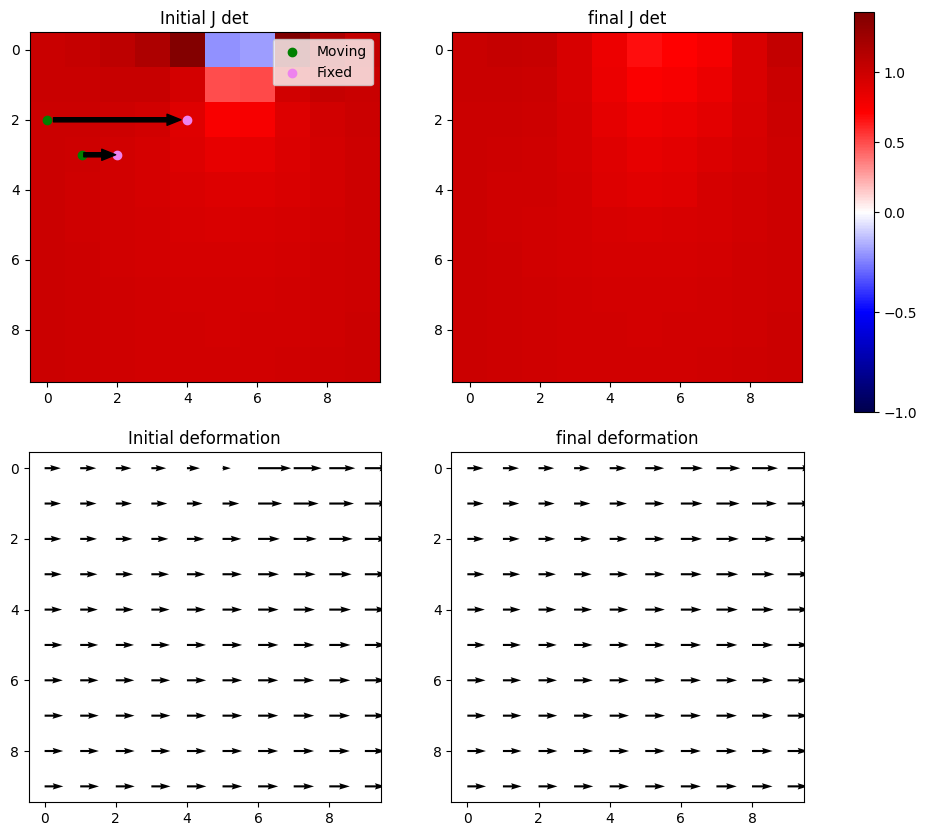

In [9]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

(15, 3) (15, 3)
deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [33, 34, 35, 17, 21, 18, 74, 73, 26, 25, 75, 22, 114, 48, 113, 115, 24, 65, 32, 66, 36, 64, 76, 154, 72, 155, 153, 62, 63, 116, 105, 57, 23, 104, 194, 112, 47, 106, 195, 156, 193, 61, 103, 152]
Iter 1: Analysing index 33: Original coord: (33, 0, 0), nearest: (33, 2, 0)
Optimization terminated successfully    (Exit mode 0)
            Current function value: 158.18183261080355
            Iterations: 27
            Function evaluations: 1378
            Gradient evaluations: 27
Optimisation for index 33 completed in 0.30670738220214844s
OP result error for index 33: 158.18183261080355
Iter 1 end: 43 -ve jacs now at [ 30  17  21  18  31  35  26  70  25  75  71  22  48  24  65  66 196  33  73  64 111 115  74 156  62  34 110  63 113 105  57  23 155 104 116 151  47 114 153 106  61 154 103] : SITK: [-17.6381793   -6.0994166   -5.69108333  -5.502

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_60876/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


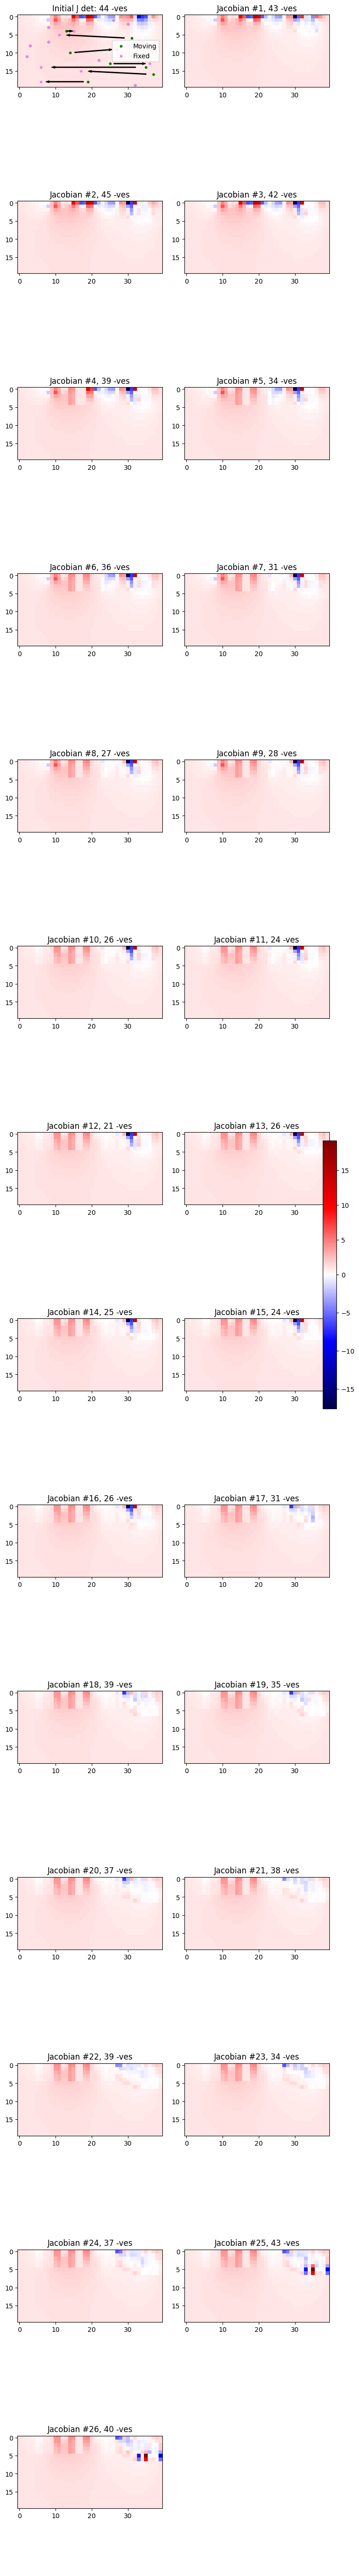

             x-def           y-def            jacobian           
               min       max   min       max       min        max
initial -13.000722  29.00161   0.0  0.999538 -9.630561  14.027545
final   -14.797283  22.73926   0.0  0.715109 -9.931673  19.233273
meshgrid shape for plot: (20, 40)


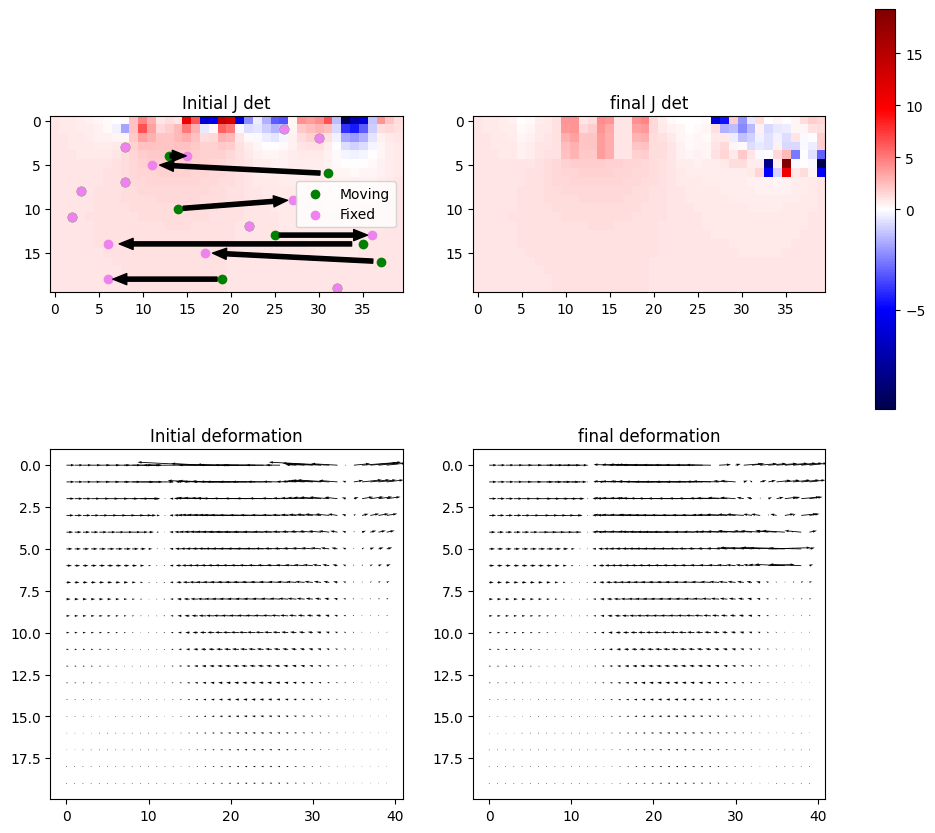

: 

In [ ]:
# data analysis

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

fixed_sample = np.zeros((1, 20, 40))

deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, mpoints, fpoints)

# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 1

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)


#test_grad(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, new_mpoints[:5], new_fpoints[:5])
run_lapl_and_correction(fixed_sample, new_mpoints, new_fpoints)

In [ ]:
# data analysis

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

deformation_field_path = "../data/base_unique_correspondences/registered_output/deformation3d.npy"
deformation_field = np.load(deformation_field_path)

# select a slice
def_shape = deformation_field.shape
print(def_shape)
deformation_i = deformation_field[:, 349].reshape((def_shape[0], 1, def_shape[2], def_shape[3]))
print(deformation_i.shape)
# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 0

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)

phi_corrected, jacobians = iterative_with_jacobians(deformation_i)
plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
# kept running for 450min

(3, 528, 320, 456)
(3, 1, 320, 456)
(13, 3) (13, 3)
deformation_i shape: (3, 1, 320, 456), phi_init shape: (2, 320, 456)
init: Negative Jacobians found at [82743, 64049, 57319, 80913, 62781, 83198, 63237, 38853, 78689, 10361, 38396, 58520, 109656, 91391, 25316, 82288, 50847, 57775, 62678, 99242, 52970, 66375, 59346, 62324, 63133, 52513, 96916, 65973, 69566, 97397, 85461, 10816, 64504, 58427, 47199, 110113, 96062, 64088, 42501, 91390, 9705, 49632, 97853, 44070, 43615, 113762, 41724, 31066, 31523, 8903, 93171, 81370, 96519, 71390, 49473, 88644, 91853, 85537, 72755, 107939, 11735, 75366, 68916, 76026, 85064, 42958, 82389, 63321, 110677, 81112, 78943, 37046, 106029, 20349, 57320, 81416, 89186, 112687, 25317, 49774, 59345, 33396, 47962, 60343, 51223, 73744, 63631, 65981, 90935, 39260, 87298, 91846, 41911, 119558, 45521, 29478, 54747, 98308, 72478, 92761, 8798, 33853, 82846, 80456, 31799, 105295, 91874, 113142, 70935, 84149, 49177, 62325, 76857, 61039, 6538, 42366, 85480, 73846, 45066, 96943